In [ ]:
from keras.layers import Input, Conv1D, GaussianNoise
from keras.models import Model
from sklearn import preprocessing
import tensorflow as tf
from sklearn.model_selection import train_test_split
import datetime
import numpy as np
import sklearn
from sklearn.externals import joblib
import pylab as pl

from keras.layers import Dense, Dropout, Conv1D, Conv2D, MaxPool1D, MaxPool2D,\
                         Flatten, UpSampling2D, UpSampling1D, Reshape,\
                         BatchNormalization
from keras.regularizers import l2
from keras.models import Sequential
import matplotlib.pyplot as plt
from tensorflow.keras.layers.experimental import preprocessing

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
encoder_info = tf.keras.models.load_model("./gdrive/MyDrive/ACSE9/my_model/encoder_info_new")
decoder_info = tf.keras.models.load_model("./gdrive/MyDrive/ACSE9/my_model/decoder_info_new")
encoder_velocity = tf.keras.models.load_model("./gdrive/MyDrive/ACSE9/my_model/encoder_velocity")
decoder_velocity = tf.keras.models.load_model("./gdrive/MyDrive/ACSE9/my_model/decoder_velocity")

In [ ]:
encoder_pred = tf.keras.models.load_model("./gdrive/MyDrive/ACSE9/my_model/encoder_pred_time")
decoder_pred = tf.keras.models.load_model("./gdrive/MyDrive/ACSE9/my_model/decoder_pred_time")

In [70]:
# dataset_time = np.load("./regular_time_velocity.npy")
# dataset_info_time = np.load("./regular_time_info.npy")
dataset_time = np.load("./gdrive/MyDrive/ACSE9/regular_time_velocity_new.npy")
dataset_info_time = np.load("./gdrive/MyDrive/ACSE9/regular_time_info_new.npy")
# dataset_time = np.load("./gdrive/MyDrive/ACSE9/regular_time_velocity.npy")
# dataset_info_time = np.load("./gdrive/MyDrive/ACSE9/regular_time_info.npy")

In [71]:
scaler_velocity_time = joblib.load('scaler_velocity_time.pkl') 

In [72]:
dataset_time.shape

(400, 36, 48, 48, 2)

In [73]:
velocity_latent_pre = encoder_velocity.predict(dataset_time[399])
result_pre = decoder_velocity.predict(velocity_latent_pre)

In [74]:
info_latent = encoder_info.predict(dataset_info_time[1])
result_info = decoder_info.predict(info_latent)

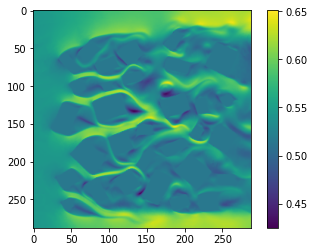

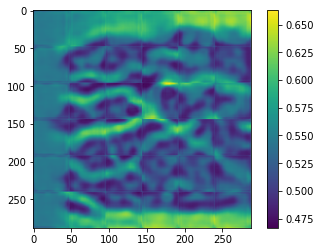

In [75]:
plot_all(dataset_time[399])
plot_all(result_pre)


In [ ]:
def preprocess_latent_time(latent_cur,latent_pre,list_):

  for i in list_:
    latent_cur[i] = latent_pre[i]

def Generate_input_time(number,latent,latent_info):

  com_input = np.zeros((1,50*5+30))
      
  com_input[0, 0: 50] = latent[number,:]
  com_input[0, 50: 100] = latent[number-1,:]
  com_input[0, 100: 150] = latent[number+1,:]
  com_input[0, 150: 200] = latent[number-6,:]
  com_input[0, 200: 250] = latent[number+6,:]
  com_input[0, 250: 250+30] = latent_info[number, :]
  return com_input

In [ ]:
mag = np.zeros((36,48,48,1))
for i in range(36):
  for j in range(48):
    for k in range(48):
      mag[i,j,k,0] = np.sqrt(result_pre[i,j,k,0]**2 + result_pre[i,j,k,1]**2)

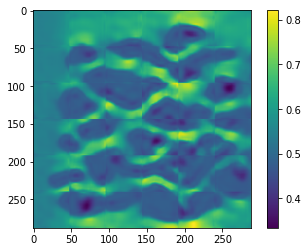

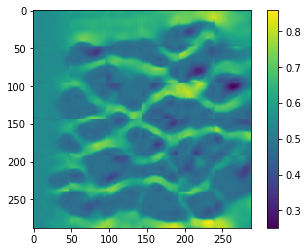

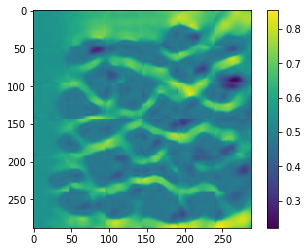

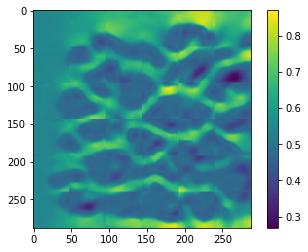

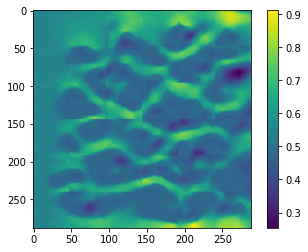

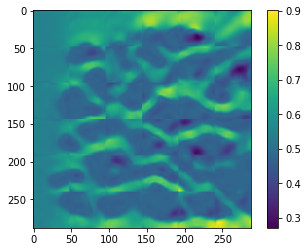

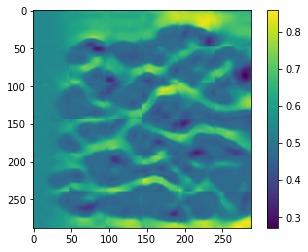

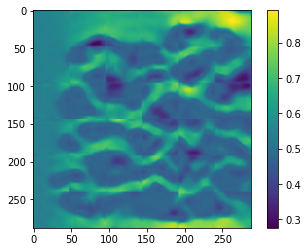

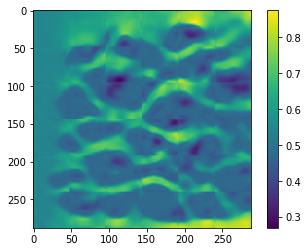

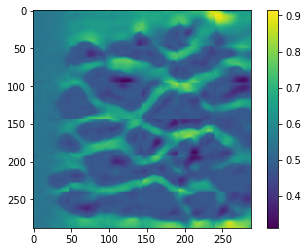

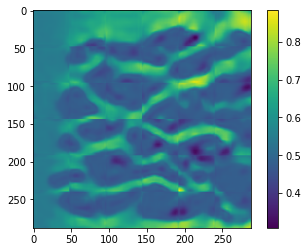

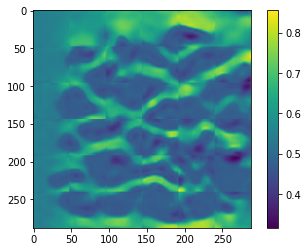

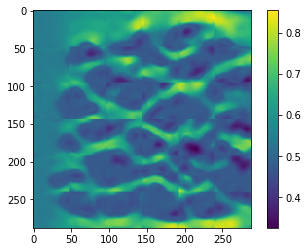

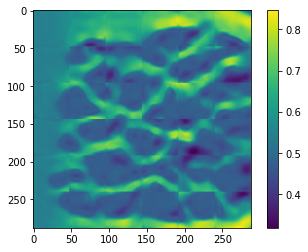

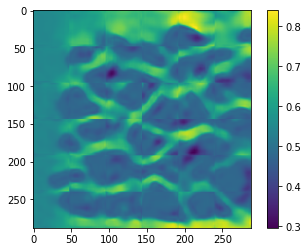

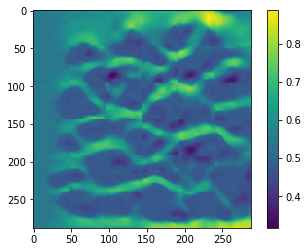

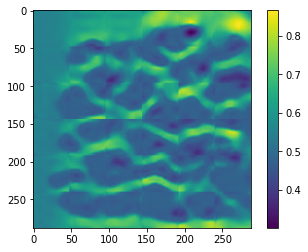

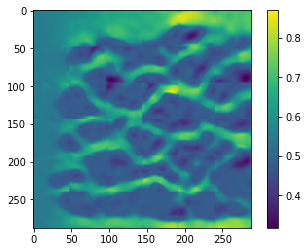

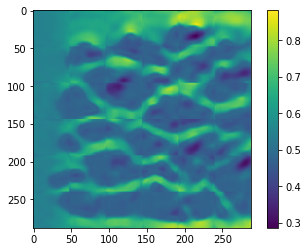

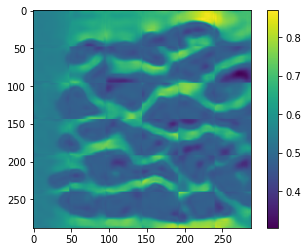

In [ ]:
info_latent = encoder_info.predict(dataset_info_time[1])
result_info = decoder_info.predict(info_latent)

layer_info = sklearn.preprocessing.MinMaxScaler()
layer_info.fit(info_latent)
info_latent_tran = layer_info.transform(info_latent)

total_result = np.zeros((400,36,48,48,2))
cur_total_result = np.zeros((400,36,48,48,2))
nTime = 399
for iTime in range(nTime):
  list_ = [7,8,9,10,13,14,15,16,19,20,21,22,25,26,27,28]
  velocity_latent_pre = encoder_velocity.predict(dataset_time[iTime])
  result_pre = decoder_velocity.predict(velocity_latent_pre)

  velocity_latent_cur = encoder_velocity.predict(dataset_time[iTime+1])
  result_cur = decoder_velocity.predict(velocity_latent_cur)

  velocity_latent_cur_tran = scaler_velocity_time.transform(velocity_latent_cur)
  #if iTime ==0:
  velocity_latent_pre_tran = scaler_velocity_time.transform(velocity_latent_pre)
  # else:
  #   velocity_latent_pre_tran = scaler_velocity_time.transform(velocity_latent_inverse)
  preprocess_latent_time(velocity_latent_cur_tran,velocity_latent_pre_tran,list_)
  
  nIter = 1
  mse_list = []
  x = []
  for iIter in range(nIter):
    mse = 0
    for i in list_:
      predict_grid = Generate_input_time(i,velocity_latent_cur_tran,info_latent_tran)
      grid_lat = encoder_pred.predict(predict_grid)
      grid = decoder_pred.predict(grid_lat)
      velocity_latent_cur_tran[i] = velocity_latent_cur_tran[i] + grid[0]

    mse_list.append(mse)
    x.append(iIter)
    list_ = list(reversed(list_))

  velocity_latent_inverse = scaler_velocity_time.inverse_transform(velocity_latent_cur_tran)
  time_result = decoder_velocity.predict(velocity_latent_inverse)
  if iTime%20 == 0:
    plot_all(time_result)
  total_result[iTime,:,:,:,0] = time_result[:,:,:,0]
  total_result[iTime,:,:,:,1] = time_result[:,:,:,1]
  cur_total_result[iTime,:,:,:,0] = result_cur[:,:,:,0]
  cur_total_result[iTime,:,:,:,1] = result_cur[:,:,:,1]

In [ ]:
time_unseen_predict = np.zeros((400,288,288,2))

for i in range(400):
  entire = get_all(total_result[i])
  time_unseen_predict[i,:,:,0] = entire[:,:,0]
  time_unseen_predict[i,:,:,1] = entire[:,:,1]

time_unseen_original = np.zeros((400,288,288,2))

for i in range(400):
  entire = get_all(cur_total_result[i])
  time_unseen_original[i,:,:,0] = entire[:,:,0]
  time_unseen_original[i,:,:,1] = entire[:,:,1]
time_unseen_info = np.zeros((400,288,288,1))
for i in range(400):
  entire = get_all(result_info)
  time_unseen_info[i,:,:,0] = entire[:,:,0]

In [ ]:
a = time_unseen_predict.swapaxes(0,3)
b = time_unseen_original.swapaxes(0,3)
c = time_unseen_info.swapaxes(0,3)

In [65]:
def vel(x):
  x = x/0.087529170101635 + -4.845808029174805
  return x

def vel_new(x):
  x = x/0.029100161128554833 + -17.710494995117188
  return x
def va(x):
  x = x/0.00039999992187501524 + 0.0
  return x

In [ ]:
a = vel_new(a)
b = vel_new(b)

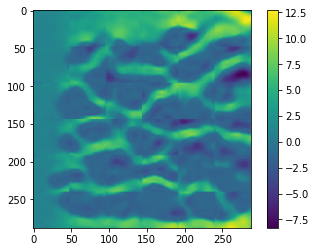

In [ ]:
plt.imshow(a[0,:,:,398])
plt.colorbar()
plt.show()

In [ ]:
np.save("./gdrive/MyDrive/ACSE9/time_unseen_predict_velocity.npy", a)
np.save("./gdrive/MyDrive/ACSE9/time_unseen_original_velocity.npy", b)

In [ ]:
np.save("./gdrive/MyDrive/ACSE9/time_unseen_info.npy", c)

In [82]:
CFD_predict = np.zeros((400,288,288,2))

for i in range(400):
  entire = get_all(dataset_time[i])
  CFD_predict[i,:,:,0] = entire[:,:,0]
  CFD_predict[i,:,:,1] = entire[:,:,1]


CFD_info = np.zeros((400,288,288,1))
for i in range(400):
  entire = get_all(dataset_info_time[i])
  CFD_info[i,:,:,0] = entire[:,:,0]

In [83]:
D = CFD_predict.swapaxes(0,3)
E = CFD_info.swapaxes(0,3)

In [84]:
D = vel_new(D)
E = va(E)

In [89]:
np.save("./gdrive/MyDrive/ACSE9/cfd_unseen_velocity.npy", D)
np.save("./gdrive/MyDrive/ACSE9/cfd_unseen_info.npy", E)

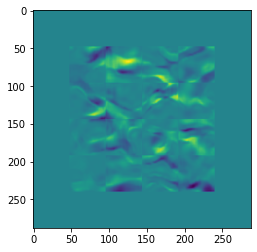

In [ ]:
plot_all((time_result-result_pre))

In [ ]:
def get_all(result):
  for i in range(6):
    x = np.concatenate((np.rot90(result[i*6]), np.rot90(result[i*6+1])), axis=1)
    x = np.concatenate((x, np.rot90(result[i*6+2])), axis=1)
    x = np.concatenate((x, np.rot90(result[i*6+3])), axis=1)
    x = np.concatenate((x, np.rot90(result[i*6+4])), axis=1)
    x = np.concatenate((x, np.rot90(result[i*6+5])), axis=1)
    if i ==0:
      y = x
    else:
      y = np.concatenate((y, x), axis=0)
  return y

In [ ]:
def plot_all(result):
  for i in range(6):
    x = np.concatenate((np.rot90(result[i*6]), np.rot90(result[i*6+1])), axis=1)
    x = np.concatenate((x, np.rot90(result[i*6+2])), axis=1)
    x = np.concatenate((x, np.rot90(result[i*6+3])), axis=1)
    x = np.concatenate((x, np.rot90(result[i*6+4])), axis=1)
    x = np.concatenate((x, np.rot90(result[i*6+5])), axis=1)
    if i ==0:
      y = x
    else:
      y = np.concatenate((y, x), axis=0)

  plt.imshow(y[:,:,0])
  plt.colorbar()
  plt.show()

In [ ]:
def plot_all_v(result):
  for i in range(6):
    x = np.concatenate((np.rot90(result[i*6]), np.rot90(result[i*6+1])), axis=1)
    x = np.concatenate((x, np.rot90(result[i*6+2])), axis=1)
    x = np.concatenate((x, np.rot90(result[i*6+3])), axis=1)
    x = np.concatenate((x, np.rot90(result[i*6+4])), axis=1)
    x = np.concatenate((x, np.rot90(result[i*6+5])), axis=1)
    if i ==0:
      y = x
    else:
      y = np.concatenate((y, x), axis=0)

  plt.imshow(y[:,:,1])
  plt.show()